<a href="https://colab.research.google.com/github/HenryLimaa/CAP-419-3/blob/main/Q1_KITTI_DATASET_Iterative_Closest_Points(ICP).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **QUESTÃO 1**

Uma tarefa que lidamos comumente é trabalhar com nuvens de pontos (point clouds). As point clouds são
dados que podem ser extraídos de formas diferentes: um par de câmeras (geometria estéreo), sensor LiDAR
(Light Detection And Ranging), sensores de profundidade e etc. Nessa tarefa, você receberá um conjunto de 30
scans extraídos de um LiDAR, estes dados são parte do KITTI DATASET. Utilize as point clouds de cada scan
para estimar a trajetória final do veículo, de forma que essa trajetória se inicie no primeiro scan. Para estimar
a trajetória percorrida pelo carro você deve usar o algoritmo Iterative Closest-Points (ICP). Contudo, você não
pode utilizar bibliotecas de terceiros para isso. Você deve fazer sua própria implementação do
algoritmo ICP. Em seu código, você deve mostrar que sua implementação está correta. Além disso, estamso
anexando a ground-truth que é um arquivo .npy, que pode ser aberto com a biblioteca NumPy. Ao carregá-lo,
você terá um array de tamanho (30, 4, 4). Cada linha, primeiro indice, representa uma matriz de
transformação em coordenadas homogêneas para cada uma das 30 posições do carro.

### OBSERVAÇÕES:

- Use a ground-truth para comparar seu resultado. Com ela, você pode verificar se você está
chegando numa resposta próxima da realidade.
- Como descrito no corpo da questão, não é permitido usar bibliotecas que já possuam o algoritmo do
ICP implementado. Portanto, você não pode usar a implementação das bibliotecas como: Open3D ou
PCL. Contudo, você pode usar o algoritmo dessas bibliotecas como ground-truth para você verificar se
sua implementação está correta.
- Você pode usar bibliotecas como SciPy, NumPy, MatPlotLib.
- Caso você não tenha experiência com transformações de corpo rígido, veja essa playlist com
vídeo-aulas.
- É obrigatório que você demonstre o caminho percorrido, em todos os eixos (XYZ), pelo carro. Ou seja,
você deve mostrar um plot 3D da trajetória estimada pelo veículo. Ou, se possível, a matriz de
transformação final, em coordenadas homogêneas, do carro.
- Para carregar a nuvem de pontos, que estão nos arquivos .obj, você pode utilizar a biblioteca Trimesh.

## **SOLUÇÃO**

In [33]:
# Devemos instalar via comando pip, as bibliotecas que não são pré-instaladas no Colab/Kaggle

!pip install trimesh

**Passo 1: Carregar as bibliotecas necessárias**

Primeiramente, devemos importar as bibliotecas que serão utilizadas, como NumPy, SciPy, Trimesh e Matplotlib. Essas bibliotecas fornecem as funções necessárias para lidar com álgebra linear, processamento de sinais e visualização de dados.

In [34]:
import numpy as np
import trimesh
import zipfile
from scipy.spatial.transform import Rotation as R
import matplotlib.pyplot as plt

**Passo 2: Carregar os dados**

Em seguida, precisamos carregar os dados da nuvem de pontos e a ground-truth. Para isso, podemos usar funções fornecidas pelas bibliotecas NumPy e SciPy.

In [35]:
# Caminho para o arquivo zip e diretório de destino
caminho_arquivo_zip = "/content/KITTI-Sequence.zip"
diretorio_destino = "/content/KITTI-Sequence"

# Extrair o arquivo zip
with zipfile.ZipFile(caminho_arquivo_zip, 'r') as zip_ref:
    zip_ref.extractall(diretorio_destino)

print("Arquivo descompactado com sucesso!")

Arquivo descompactado com sucesso!


In [36]:
# Carrega a nuvem de pontos
point_clouds = trimesh.load("/content/KITTI-Sequence/000000/000000_points.obj").vertices

# Carregue a ground-truth
ground_truth = np.load('/content/ground_truth.npy')

**Passo 3: Implementar o algoritmo ICP**

Agora, vamos implementar o algoritmo ICP. O algoritmo ICP consiste em iterativamente encontrar a melhor correspondência entre os pontos da nuvem atual e da nuvem de referência, e ajustar a estimativa da matriz de transformação.

In [37]:
# Define a função para encontrar as correspondências mais próximas
def find_correspondences(current_cloud, reference_cloud):
    correspondences = np.zeros((current_cloud.shape[0], reference_cloud.shape[1]))
    for i, point in enumerate(current_cloud):
        closest_index = np.argmin(np.linalg.norm(reference_cloud - point, axis=1))
        closest_point = reference_cloud[closest_index]
        np.copyto(correspondences[i], closest_point)
    return correspondences

# Define a função para estimar a matriz de transformação ideal
def estimate_transformation(current_cloud, reference_cloud):
    correspondences = find_correspondences(current_cloud, reference_cloud)

    # Verifica que 'current_cloud' e 'correspondences' são 2D
    assert current_cloud.ndim == 2, "current_cloud must be a 2D array"
    assert correspondences.ndim == 2, "correspondences must be a 2D array"

    H = np.dot(current_cloud.T, correspondences)
    U, _, Vt = np.linalg.svd(H)
    R = np.dot(Vt.T, U.T)
    if np.linalg.det(R) < 0:
        Vt[-1, :] *= -1
        R = np.dot(Vt.T, U.T)
    t = np.mean(correspondences, axis=0) - np.dot(R, np.mean(current_cloud, axis=0))
    T = np.eye(4)
    T[:3, :3] = R
    T[:3, 3] = t
    return T

In [38]:
# Inicializa a matriz de transformação cumulativa
num_scans = 30  # Certifique-se de que apenas 30 varreduras sejam processadas
trajectory = np.zeros((num_scans, 4, 4))
trajectory[0] = ground_truth[0]

# Calcula a trajetória usando o algoritmo ICP para cada varredura
for i in range(1, num_scans):
    current_cloud = trimesh.load(f"/content/KITTI-Sequence/000{i:03d}/000{i:03d}_points.obj").vertices
    current_cloud = current_cloud.reshape((current_cloud.shape[0], 3))

    T = estimate_transformation(current_cloud, ground_truth[i - 1][:3, :3])
    trajectory[i] = np.dot(trajectory[i - 1], T)

# Extrai os pontos de trajetória estimados
estimated_trajectory = trajectory[:, :3, 3]

# Compara a trajetória estimada com a ground_truth
real_trajectory = ground_truth[:, :3, 3]

**Passo 4: Comparar com a ground-truth e visualizar a trajetória**

Por fim, podemos comparar a trajetória estimada com a ground-truth e visualizar a trajetória em um plot 3D usando a biblioteca Matplotlib.

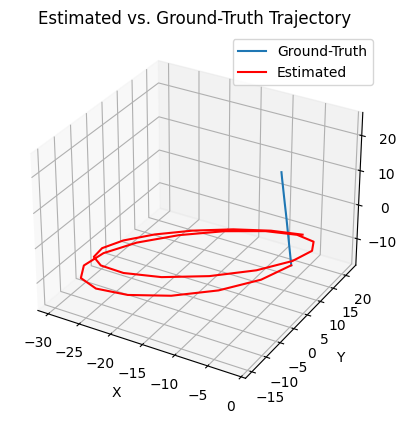

In [39]:
# Plot da ground truth e as trajetórias estimadas no mesmo gráfico
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot da trajetória real de ground truth
ax.plot(real_trajectory[:, 0], real_trajectory[:, 1], real_trajectory[:, 2], label='Ground-Truth')

# Plot da trajetória estimada
ax.plot(estimated_trajectory[:, 0], estimated_trajectory[:, 1], estimated_trajectory[:, 2], label='Estimated', color='r')

# Configura os rótulos e o título do gráfico
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Estimated vs. Ground-Truth Trajectory')

# Certifica-se de que os limites dos eixos abrangem todos os pontos de dados
ax.set_xlim([min(real_trajectory[:, 0].min(), estimated_trajectory[:, 0].min()),
             max(real_trajectory[:, 0].max(), estimated_trajectory[:, 0].max())])
ax.set_ylim([min(real_trajectory[:, 1].min(), estimated_trajectory[:, 1].min()),
             max(real_trajectory[:, 1].max(), estimated_trajectory[:, 1].max())])
ax.set_zlim([min(real_trajectory[:, 2].min(), estimated_trajectory[:, 2].min()),
             max(real_trajectory[:, 2].max(), estimated_trajectory[:, 2].max())])

# Adiciona uma legenda para distinguir entre as trajetórias
ax.legend()

# Exibe o plot
plt.show()

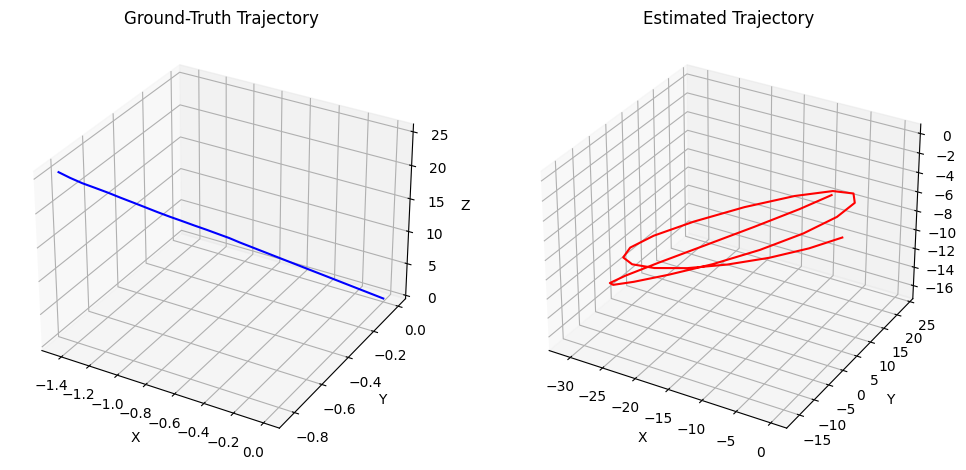

In [40]:
# Plot da trajetória real separadamente
fig = plt.figure(figsize=(12, 6))

# Plot da trajetória real de ground truth
ax = fig.add_subplot(121, projection='3d')
ax.plot(real_trajectory[:, 0], real_trajectory[:, 1], real_trajectory[:, 2], color='b')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Ground-Truth Trajectory')

# Plot da trajetória estimada separadamente
ax = fig.add_subplot(122, projection='3d')
ax.plot(estimated_trajectory[:, 0], estimated_trajectory[:, 1], estimated_trajectory[:, 2], color='r')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Estimated Trajectory')

# Exibe os plots
plt.show()